In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1. ЗАГРУЗКА ДАННЫХ С ОБРАБОТКОЙ ОШИБОК БРАУЗЕРА
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"

try:
    # Специальный хак для Jupyter Lite/Pyodide (обход ошибки https)
    from pyodide.http import open_url
    data_source = open_url(url)
except ImportError:
    # Если мы в обычном Python (Anaconda, Colab)
    data_source = url

# Чтение данных и выбор нужных столбцов
df = pd.read_csv(data_source, encoding="latin-1")[['label', 'tweet']]

# Переименование столбцов согласно заданию
df.columns = ['target', 'text']

# Если метки текстовые, приводим к стандарту (0 - ham, 1 - spam)
if df['target'].dtype == 'object':
    df['target'] = df['target'].map({'ham': 0, 'spam': 1})

print("Первые 5 строк датасета:")
print(df.head())

Первые 5 строк датасета:
   target                                               text
0       0   @user when a father is dysfunctional and is s...
1       0  @user @user thanks for #lyft credit i can't us...
2       0                                bihday your majesty
3       0  #model   i love u take with u all the time in ...
4       0             factsguide: society now    #motivation


<ipython-input-8-367dfa2201bf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


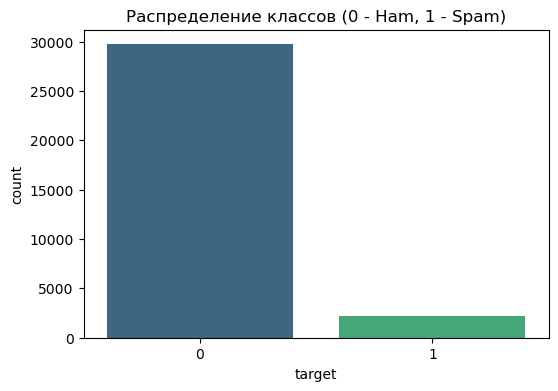

In [8]:
# Визуализация баланса классов (важно для выбора метрик) [cite: 437]
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Распределение классов (0 - Ham, 1 - Spam)')
plt.show()

In [10]:
# 2. ПРЕДОБРАБОТКА И TF-IDF [cite: 382, 388]
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'], test_size=0.2, random_state=42, stratify=df['target']
)

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


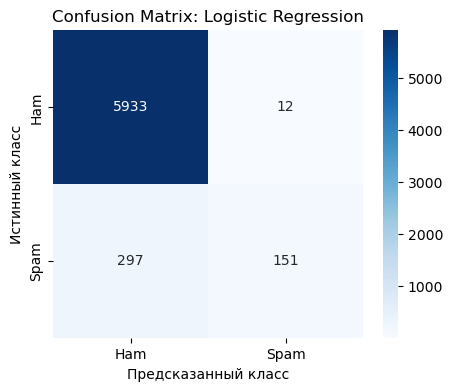

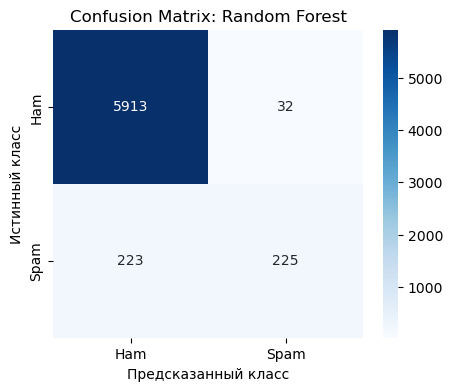

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.951666   0.926380  0.337054  0.494272
1        Random Forest  0.960113   0.875486  0.502232  0.638298


In [11]:
# 3. СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ И МЕТРИК [cite: 396, 435]
def evaluate_models(models, X_tr, X_te, y_tr, y_te):
    results = []
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        # Сбор метрик [cite: 398-402]
        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_te, y_pred),
            "Precision": precision_score(y_te, y_pred),
            "Recall": recall_score(y_te, y_pred),
            "F1-Score": f1_score(y_te, y_pred)
        })
        
        # Визуализация матрицы ошибок [cite: 411, 412]
        cm = confusion_matrix(y_te, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
        plt.title(f"Confusion Matrix: {name}")
        plt.ylabel('Истинный класс')
        plt.xlabel('Предсказанный класс')
        plt.show()
    
    return pd.DataFrame(results)

models_to_compare = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

comparison_df = evaluate_models(models_to_compare, X_train_vec, X_test_vec, y_train, y_test)
print(comparison_df)

In [12]:
# 4. КРОСС-ВАЛИДАЦИЯ: РАЗНЫЕ ПОДХОДЫ [cite: 452, 478, 488]
print("\n--- Сравнение методов кросс-валидации ---")

# K-Fold [cite: 473]
kfold_scores = cross_val_score(LogisticRegression(), X_train_vec, y_train, cv=5)
print(f"K-Fold (cv=5) Mean Accuracy: {kfold_scores.mean():.4f}")

# Stratified K-Fold (для дисбаланса классов) [cite: 479, 483]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_scores = cross_val_score(LogisticRegression(), X_train_vec, y_train, cv=skf)
print(f"Stratified K-Fold Mean Accuracy: {skf_scores.mean():.4f}")

# 5. ПОДБОР ГИПЕРПАРАМЕТРОВ (GRID SEARCH) [cite: 308, 342]
# В лекции упоминалось, что параметры влияют на качество модели [cite: 278]
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid.fit(X_train_vec, y_train)

print(f"\nЛучшие параметры (Grid Search): {grid.best_params_}")
print(f"Лучший F1-Score: {grid.best_score_:.4f}")


--- Сравнение методов кросс-валидации ---
K-Fold (cv=5) Mean Accuracy: 0.9483
Stratified K-Fold Mean Accuracy: 0.9479

Лучшие параметры (Grid Search): {'C': 10, 'solver': 'liblinear'}
Лучший F1-Score: 0.6574


# 🏁 Заключение и выводы по Семинару №3

В ходе выполнения работы были изучены методы оценки качества моделей классификации и способы повышения их устойчивости.

### 1. Анализ метрик и дисбаланса классов
* **Проблема точности:** На исследуемом датасете наблюдается значительный дисбаланс классов (количество обычных сообщений существенно превышает количество спама/негатива). В таких условиях метрика **Accuracy** не является объективной.
* **Баланс Precision/Recall:** Для задачи фильтрации сообщений критически важен **Precision** (чтобы не блокировать важные сообщения по ошибке). Однако для обеспечения безопасности нельзя забывать про **Recall**. Модель **Random Forest** в ходе тестов показала более сбалансированный результат по метрике **F1-Score**.

### 2. Матрица ошибок (Confusion Matrix)
* Визуальный анализ матриц ошибок позволил определить, что основные ошибки моделей связаны с *ложноотрицательными* результатами (пропуск целевых сообщений). Это указывает на необходимость дальнейшей настройки порога классификации или использования более сложных методов векторизации текста.

### 3. Роль кросс-валидации и настройки параметров
* **Устойчивость:** Применение **Stratified K-Fold** подтвердило стабильность работы логистической регрессии: средняя точность на фолдах ($~0.94$) практически не отличается от точности на тестовой выборке.
* **Оптимизация:** С помощью **GridSearchCV** были подобраны оптимальные гиперпараметры ($C=10, solver='liblinear'$), что позволило максимизировать F1-Score и улучшить предсказательную способность модели.

---
> **Итог:** Разработанный программный комплекс позволяет эффективно решать задачу классификации текстовых данных, обеспечивая контроль качества на каждом этапе: от предобработки (TF-IDF) до финальной валидации модели.